This notebook follows the same pipeline laid out in the "**Decot, Namboodiri et al. DA evoked data analysis**" notebook. So please check that notebook out first. The changes here are mostly in the organization of the data. Most functions in this notebook are just copied over and slightly modified if necessary from that notebook. The files needed to run this notebook should have been downloaded as part of running the first code cell of that notebook.

## Import all required modules

In [48]:
import scipy.io as sio
import scipy.stats as stats
import numpy as np
import os
import errno
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
% matplotlib inline

import seaborn as sns

import h5py
from multiprocessing import Pool, cpu_count

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA as ICA
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

import pandas as pd

## Visualize raw data

First, we will define different functions for this step. The actual implementation of the visualization will be done later in the notebook. 

The data is organized as an HDF5 file with the following levels: 
1. Condition (CHR2 or EYFP) 
2. Animals 
3. Frequency of paw-stimulation 
4. Trials 

In [6]:
def mkdir_p(path):
    #makes a new directory if it doesn't exist
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
def calculate_shape_of_data(f, freqofinterest):
    #This function calculates the shape of each trial's data
    
    #Parameters:
    # 1. filehandle to the HDF5 file
    # 2. String representing the frequency of interest
    
    #Returns: Shape of each trial's data

    conditions = f['/'].keys()
    animals = f['/'][conditions[0]].keys()
    trials = f['/'][conditions[0]][animals[0]][freqofinterest].keys()
    sample_data = f['/'][conditions[0]][animals[0]][freqofinterest][trials[0]]
    (numx, numy, numz, numt) = sample_data.shape
    
    return (numx, numy, numz, numt)

def calculate_response_preMION(MIONdata, 
                               condition, 
                               animal, 
                               indices_for_windows):
    # This function calculates the preMION injection response so as to calculate the
    # %CBV value for the response around stimulation using the equation
    # %CBV = ln(S_baseline/S(t))/ln(S_preMION/S_baseline)
    
    #Parameters:
    #   1. The handle to the HDF5 file containing the MION injection data to calculate %CBV
    #   2. condition: either CHR2 or EYFP
    #   3. animal id
    #   4. indices_for_windows is the specification of time windows of interest. In this experiment,
    #      there is a baseline period between time=0 and time=20, followed by the first stimulation
    #      between 20 to 30, followed by the post-stimulation period of the first stimulation, followed
    #      by the second stimulation between 60 and 70, followed by the post-stimulation period of 
    #      the second stimulation from 70 to 100. 100 is also equal to numt, the total number of time
    #      samples. Hence, in this case, indices_for_windows = [0, 20, 30, 60, 70, 100]. 
    
    #      For the preMION, we will calculate the preMION response as the mean response during the 
    #      first indices_for_windows[0] time points.
    
    data = MIONdata[condition][animal]
    temp = np.mean(data[:,:,:,:indices_for_windows[1]], axis=3)
    temp[temp==0]=np.nan
    response_preMION = np.nanmean(temp)
    return response_preMION
            
def calculate_meansignal_across_animals(f, 
                                        (numx,numy,numz,numt),
                                        freqofinterest,
                                        MIONdata, 
                                        indices_for_windows):
    #This function calculates the mean signal per voxel across all animals and all runs
    
    #Parameters:
    #   1. Handle to the HDF5 file containing the data. Defined later
    #   2. Tuple of the shape of the data from each trial in the order 
    #            a. number of x voxels, b. number of y voxels, c. number of z voxels, d. number of time samples
    #   3. The frequency of interest for analysis
    
    # Returns: Mean data for all voxels across all animals and runs for both conditions as a dictionary.
    
    conditions = f['/'].keys()
    mean_data_for_condition = {}
    for condition in conditions:
        animals = f['/'][condition].keys()
        data_for_condition = {}
        data_for_condition['pre'] = np.nan*np.ones((len(animals),numx,numy,numz,numt))
        data_for_condition['post'] = np.nan*np.ones((len(animals),numx,numy,numz,numt))
        for a, animal in enumerate(animals):
            if os.path.join(condition, animal, freqofinterest) in f:
                response_preMION = calculate_response_preMION(MIONdata, condition, animal, indices_for_windows)
                
                tempruns = f['/'][condition][animal][freqofinterest].keys()
                runs = {}
                runs['pre'] = [r for r in tempruns if 'pre' in r]
                runs['post'] = [r for r in tempruns if 'post' in r]
                data = {}
                data['pre'] = np.nan*np.ones((len(runs['pre']),numx,numy,numz,numt))
                data['post'] = np.nan*np.ones((len(runs['post']),numx,numy,numz,numt))
                for r, run in enumerate(runs['pre']):
                    fulldata = f['/'][condition][animal][freqofinterest][run]
                    
                    temp = np.mean(fulldata[:,:,:,:indices_for_windows[1]], axis=3)   
                    temp[temp==0]=np.nan
                    response_baseline = temp
                    meanresponse_baseline = np.nanmean(temp)
                    signal = (np.tile(np.expand_dims(response_baseline, axis=3), (1,1,1,numt)) - fulldata)
                    normalization = (response_preMION - meanresponse_baseline)
                    normalizedsignal = np.divide(signal, np.tile(np.expand_dims(normalization,axis=3), (1,1,1,numt)))
                    
                    data['pre'][r,:] = normalizedsignal
                for r, run in enumerate(runs['post']):
                    fulldata = f['/'][condition][animal][freqofinterest][run]
                    
                    temp = np.mean(fulldata[:,:,:,:indices_for_windows[1]], axis=3)   
                    temp[temp==0]=np.nan
                    response_baseline = temp
                    meanresponse_baseline = np.nanmean(temp)
                    signal = (np.tile(np.expand_dims(response_baseline, axis=3), (1,1,1,numt)) - fulldata)
                    normalization = (response_preMION - meanresponse_baseline)
                    normalizedsignal = np.divide(signal, np.tile(np.expand_dims(normalization,axis=3), (1,1,1,numt)))
                    
                    data['post'][r,:] = normalizedsignal
                meandata={}
                meandata['pre'] = np.mean(data['pre'], axis=0) # Mean data across all pre runs for a given animal
                meandata['post'] = np.mean(data['post'], axis=0) # Mean data across all pre runs for a given animal
                data_for_condition['pre'][a,:] = meandata['pre'] 
                data_for_condition['post'][a,:] = meandata['post'] 
        mean_data_for_condition[condition] = {}
        mean_data_for_condition[condition]['pre'] = np.nan_to_num(np.mean(data_for_condition['pre'], axis=0)) #Mean across all animals
        mean_data_for_condition[condition]['post'] = np.nan_to_num(np.mean(data_for_condition['post'], axis=0)) #Mean across all animals
    return mean_data_for_condition


def plot_traces_for_each_voxel(data, 
                               indices_for_windows, 
                               sortby='stimresponse',
                               periodofinterest='poststim', 
                               sortbypreorpost='pre',
                               numvoxelstoshow = 500,
                               pca_results_paths=None, 
                               sortbypc=None):
    # Plots the traces for each voxel. One could use this function for visualizing data from
    # individual animals. But here, we use it to visualize raw voxel traces for the normalized
    # mean data across all animals and runs. This is calculated by the above two functions.
    # The voxels can be sorted by either stimulus response or PCA weights.
    # Obviously, sorting by PCA weights can be done only if the corresponding PCA has been 
    # done. We will calculate this later. But at that stage, we can call this function 
    # to sort the voxel traces by the voxel's weight on any PC.

    #Parameters:
    #   1. Data to plot. Is a dictionary containing data for each condition. Each condition's data 
    #      has shape (numx,numy,numz,numt)
    #   2. indices_for_windows is the specification of time windows of interest. See above
    #   3. sortby decides whether the voxels should be sorted by stimulus response of PC weights.
    #      sortby='stimresponse' or 'pcweights'. Default is stimresponse
    #   4. Period of interest to sort the voxels by if sortby = 'stimresponse'.
    #      Can be either 'stim' or 'poststim'. For each case, the mean response in that period
    #      will be used to sort the voxels.
    #   5. sortbypreorpost decides whether the voxels should be sorted by the pre-pairing values or
    #      post-pairing values. Set it to 'self' if you want pre and post data sorted within themselves.
    #      In this case, the voxel order will not be maintained in the figure.
    #   6. Number of voxels to show in the plot.
    #   7. pca_results_path: Dictionary containing the paths where the PCA results (pickled files) for 
    #      each condition are stored.
    #   8. sortbypc is the principal component whose weights should be used to sort the voxels
    #      if sortby=='pcweights'
    
    # Returns: Figure handle for the plot. Useful for saving the figure later.
    
    
    conditions = data.keys()
    conditions.sort()
    prepostkeys = data[conditions[0]].keys()
    (numx,numy,numz,numt)=data[conditions[0]][prepostkeys[0]].shape
    numvoxels = numx*numy*numz
    
    #For plotting, we want to set the colorbar minimum and maximum as the values across all conditions
    #This is first calculated, along with the sorting order for the voxels
    
    fig, allax = plt.subplots(2,2, sharex='col', sharey='row', figsize=(8,10))
    
    #Define the periods of interest: stimperiod and poststimperiod
    poststimperiod = np.arange(indices_for_windows[2],indices_for_windows[3])
    stimperiod = np.arange(indices_for_windows[1],indices_for_windows[2])
    allrows = np.arange(numx*numy*numz) #useful for indexing all rows later
    
    flattened_data = {} #Will contain spatially flattened data
    sortvoxels = {} #Will contain sorting order for the voxels
        
    def calculate_cbarlims_sortvoxels():
        
        cmin = np.nan*np.ones((len(conditions),len(prepostkeys)))
        cmax = np.nan*np.ones((len(conditions),len(prepostkeys)))
        for c, condition in enumerate(conditions):
            flattened_data[condition] = {}
            sortvoxels[condition] = {}
            for prepost in prepostkeys:
                if sortbypreorpost=='self':
                    prepostofinterest = prepost
                elif sortbypreorpost=='pre':
                    prepostofinterest = 'pre'
                elif sortbypreorpost=='post':
                    prepostofinterest = 'post'
                    
                flattened_data[condition][prepost] = np.reshape(data[condition][prepost],
                                                                          (numvoxels, numt))

                if sortby=='stimresponse' and periodofinterest=='poststim':
                    sortvoxels[condition][prepost] = np.argsort(
                        np.nanmean(flattened_data[condition][prepostofinterest][np.ix_(allrows,poststimperiod)], axis=1))
                elif sortby=='stimresponse' and periodofinterest=='stim':
                    sortvoxels[condition][prepost] = np.argsort(
                        np.nanmean(flattened_data[condition][prepostofinterest][np.ix_(allrows,stimperiod)], axis=1))
                elif sortby=='pcweights':                
                    if sortbypc is None:
                        raise Exception('Please specify which PC to use to sort the voxels')
                    if pca_results_paths is None:
                        raise Exception('Please specify the paths to the pickle file containing PCA results')

                    pca = joblib.load(pca_results_paths[condition][prepostofinterest])
                    voxel_components = pca.components_.T
                    sortvoxels[condition][prepost] = np.argsort(np.abs(voxel_components[:,sortbypc]))

            cmin[c,0] = np.amin(flattened_data[condition]['pre'][sortvoxels[condition][prepost][-numvoxelstoshow:],:])
            cmax[c,0] = np.amax(flattened_data[condition]['pre'][sortvoxels[condition][prepost][-numvoxelstoshow:],:]) 

            cmin[c,1] = np.amin(flattened_data[condition]['post'][sortvoxels[condition][prepost][-numvoxelstoshow:],:])
            cmax[c,1] = np.amax(flattened_data[condition]['post'][sortvoxels[condition][prepost][-numvoxelstoshow:],:]) 

        cmin = np.amin(cmin)
        cmax = np.amax(cmax)
        
        return cmin, cmax, sortvoxels
    
    cmin, cmax, sortvoxels = calculate_cbarlims_sortvoxels()
    
    # Create the plots
    for c, condition in enumerate(conditions):
        for p, prepost in enumerate(prepostkeys):
            allax[0,p].set_title(prepost, size='large')
            ax = allax[c,p]   
            voxelorder = sortvoxels[condition][prepost][-numvoxelstoshow:]
            sns.heatmap(flattened_data[condition][prepost][voxelorder[::-1],:], 
                        ax=ax, cmap=plt.get_cmap('viridis'), vmin=cmin, vmax=cmax, linewidth=0)
            for epochindex in range(1,indices_for_windows.shape[0]-1):
                ax.plot(indices_for_windows[epochindex]*np.array([1, 1]), [0, numvoxelstoshow], '--k', linewidth=1)
            ax.grid(b=False)          
        
            allax[1,p].set_xlabel('Time (s)')
            allax[1,p].set_xticks(range(0, indices_for_windows[-1]+1, 10))
            allax[1,p].set_xticklabels([str(a) for a in range(0, indices_for_windows[-1]+1, 10)])
        
    
        allax[c,0].set_ylabel('Voxel number')
        allax[c,0].set_yticks(range(0, numvoxelstoshow, numvoxelstoshow/10))
        allax[c,0].set_yticklabels([str(numvoxelstoshow-a) for a in range(0, numvoxelstoshow, numvoxelstoshow/10)])
        
        pad = 5 # in points
        allax[c,0].annotate(condition, xy=(0, 0.5), xytext=(-allax[c,0].yaxis.labelpad - pad, 0),
                xycoords=allax[c,0].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
    fig.tight_layout()
    fig.subplots_adjust(left=0.15, top=0.95)
    
    return fig

Now that the above functions are declared, we are ready to use them to visualize the data.

First, we need to set all the parameters of interest. They are:
1. **indices_for_windows**: the specification of time windows of interest. In this experiment, there is a baseline period between time=0 and time=20, followed by the first stimulation between 20 to 30, followed by a post-stimulation period until 100s. 100 is also equal to numt, the total number of time samples. Hence, in this case, indices_for_windows = [0, 20, 30, 100]
2. **working_directory**  : This will be the local working directory where all data and results are stored.
3. **f**                  : file handle for the HDF5 file containing the data
4. **freqofinterest**     : String representing the frequency of interest

In [3]:
indices_for_windows = np.array([0, 20, 30, 100])

working_directory = '/home/stuberlab/temp/heather data working directory'

f = h5py.File(os.path.join(working_directory, 'pawstim_data.hdf5'),'r') #Read-only  
freqofinterest = str(9) #String representing the frequency of interest

(numx, numy, numz, numt) = calculate_shape_of_data(f, freqofinterest)

MIONdata = h5py.File(os.path.join(working_directory, 'pawstim_MIONdata.hdf5'),'r') #Read-only  

In [4]:
mean_data_for_condition = calculate_meansignal_across_animals(f, 
                                                              (numx,numy,numz,numt),
                                                              freqofinterest, 
                                                              MIONdata,
                                                              indices_for_windows)

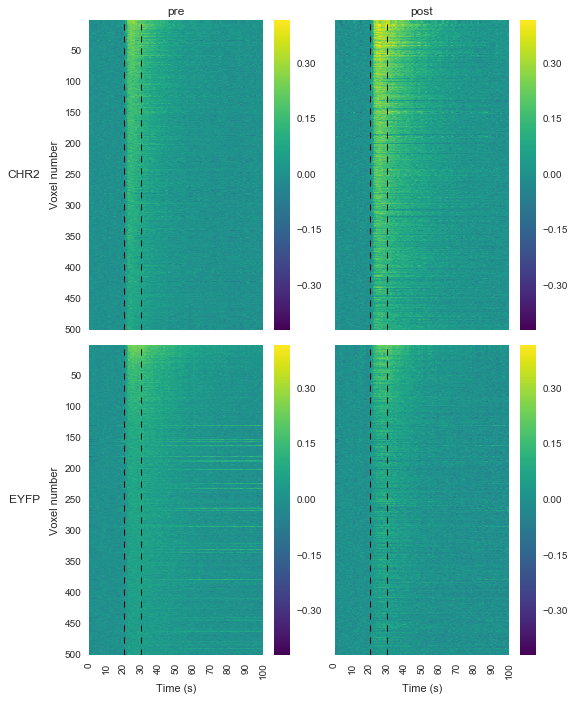

In [7]:
fig = plot_traces_for_each_voxel(mean_data_for_condition,
                                 indices_for_windows,
                                 periodofinterest='stim',
                                 numvoxelstoshow = 500)

At this point, you can save the figure if you want, to the path you set below.

In [8]:
results_directory = os.path.join(working_directory,'pawstimresults',freqofinterest+'Hz')
mkdir_p(results_directory)

In [ ]:
numvoxelstoshow = 500
sortby = 'Stimresponse_stimperiod'
sortbypreorpost = 'pre'
path_to_save = os.path.join(results_directory,'Top%dvoxels_pawstim_sortedby%s_ordering_%s'%(numvoxelstoshow,
                                                                                                sortby,
                                                                                                sortbypreorpost))
fig.savefig(path_to_save + '.png', format='png', dpi=300)
fig.savefig(path_to_save + '.pdf', format='pdf')

In [ ]:
reset_selective fig

Save mean data as an HDF5 file to later combine with the pairing data. This will not be used in this notebook. But in the analysis of pairing done in "Paw stim pairing analysis" notebook, this will come in handy.

In [ ]:
path_to_meandata = os.path.join(results_directory,'mean_data_for_condition.hdf5')
meandata_handle = h5py.File(path_to_meandata,'a')
conditions = f.keys()
for condition in conditions:
    g = meandata_handle.create_group(condition)
    for prepost in mean_data_for_condition[condition].keys():
        g.create_dataset(prepost, data=mean_data_for_condition[condition][prepost])
meandata_handle.close()

## Convert data into PCA space

Now, we will do PCA on the data to get an unbiased factorization of the data. The PCA is done to compress the dimensionality of the voxels. These first set of functions are useful for performing the PCA and visualizing their raw results. Additional functions for advanced visualization will be defined later.

In [9]:
def preprocess_data(data):
    # This function flattens the data along the spatial dimensions. So size of data will
    # change from (numx, numy, numz, numt) to (numx*numy*numz, numt)
    
    #Parameters:
    #   1. The data to be flattened
    
    # Returns: Flattened data
    flattened_data = np.reshape(data,(np.prod(data.shape[:-1]), data.shape[3]))
    return flattened_data

def PCA_decomp(data, 
               pca_results_path,
               indices_for_windows, 
               min_variance_explained=0.8):
    # This function is called to do PCA decomposition. This checks if the PCA has already
    # been done by checking if a pickled file exists in pca_results_path. If this file
    # exists, it just loads those results. Otherwise, it performs the PCA decomposition.
    
    #Parameters:
    #   1. The data to perform PCA on. Shape: (numx, numy, numz, numt)
    #   2. pca_results_path: Path to where the PCA result would have been stored
    #                        if PCA has already been performed for this data.
    #   3. The minimum amount of variance that should be explained. The number of 
    #      PCs stored will be determined by this number.
    
    # Returns: Data in PCA space
    
    if os.path.isfile(pca_results_path): #has PCA already been done?
        return transform_from_loadedpca(data, pca_results_path)
    else:
        return perform_PCA_decomp(data, pca_results_path, indices_for_windows, min_variance_explained)

def transform_from_loadedpca(data, 
                             pca_results_path):
    # This function transforms inputted data based on stored PCA results for that data.
    
    #Parameters:
    #   1. The data on which PCA was performed.
    #   2. pca_results_path: Path to where the PCA result would have been stored
    #                        if PCA has already been performed for this data.
    
    # Returns: Data in PCA space
    
    flattened_data = preprocess_data(data)
    pca = load_calculated_pca(pca_results_path)
    compressed_data = pca.transform(flattened_data.T).T #transform back to shape n_components x n_timepoints
    return compressed_data

def perform_PCA_decomp(data, 
                       pca_results_path, 
                       indices_for_windows, 
                       min_variance_explained=0.8):
    # This function performs the PCA decomposition. This is called only if 
    # there aren't any results from a previous run stored in pca_results_path.
    
    #Parameters:
    #   1. The data to perform PCA on. Shape: (numx, numy, numz, numt)
    #   2. pca_results_path: Path to where the PCA result should be stored.
    #   3. The minimum amount of variance that should be explained. The number of 
    #      PCs stored will be determined by this number.
    
    # Returns: Data in PCA space
    
    flattened_data = preprocess_data(data)
    pca = PCA(n_components=min_variance_explained)
    pca.fit(flattened_data.T) 
    compressed_data = pca.transform(flattened_data.T).T #transform back to shape n_components x n_timepoints
    pca, compressed_data = standardize_pca_sign(pca, compressed_data, indices_for_windows)
    joblib.dump(pca, pca_results_path)
    return compressed_data

def load_calculated_pca(pca_results_path):
    # This function loads the calculated PCA object.
    
    #Parameters:
    #   1. pca_results_path: Path to where the PCA result would have been stored
    #                        if PCA has already been performed for this data.
    
    # Returns: sklearn PCA object
    pca = joblib.load(pca_results_path)
    return pca

def standardize_pca_sign(pca, 
                         compressed_data,
                         indices_for_windows,
                         criterion='positivestimresponse'):
    # The PCs are only defined upto a negative sign, i.e. a 180 degree rotated PC vector
    # is equivalently a PC vector. This function prevents this ambiguity by enforcing
    # the sign of each PC to be such that the derivative of the trace is positive at the 
    # onset of the first stimulation. Other forms of standardization could also be used.  
    # Obviously, this works only for this current experiment with stimulation. In case
    # there is no stimulation, you could set the criterion to "positiveslope" in which 
    # case the function will ensure that the PC's trace has a positive linear trend 
    # through the recording.
    
    #Parameters:
    #   1. The sklearn PCA object.
    #   2. compressed_data: Data in PCA space
    #   3. indices for windows. Explained above
    #   4. criterion for standardization. Set to positivestimresponse to ensure that
    #      the PCs have a positive stimulation response.
    
    # Returns: Sign standardized input parameters
    for pc in range(compressed_data.shape[0]):
        trace = compressed_data[pc,:].T
        if criterion=='positivestimresponse':
            if np.diff(trace)[indices_for_windows[1]]<0:
                compressed_data[pc,:] = -compressed_data[pc,:]
                pca.components_[pc,:] = -pca.components_[pc,:]  
        elif criterion=='positiveslope':
            time = np.arange(trace.shape[0]).T
            time = sm.add_constant(time)
            lm = sm.OLS(trace, time).fit()
            if lm.params[1] < 0: #if slope < 0, flip the PC vector and the trace
                compressed_data[pc,:] = -compressed_data[pc,:]
                pca.components_[pc,:] = -pca.components_[pc,:]
    return pca, compressed_data

def extract_pc_vectors(pca_results_path, 
                       (numx, numy, numz)):
    # This function is used to extract the PC vectors from the stored results 
    # in pca_results_path and reshapes them to the original voxel tiling.
    
    #Parameters:
    #   1. PCA results path
    
    # Returns: pca_vectors
    
    pca = load_calculated_pca(pca_results_path)
    pca_vectors = np.reshape(pca.components_.T, (numx,numy,numz,pca.components_.shape[0]))
    return pca_vectors

def plot_variance_explained_per_pc(pca_results_path,
                                   fig=None,
                                   ax=None,
                                   label='',
                                   numpcs=None):
    # This function plots the % of variance explained by each PC.
    
    #Parameters:
    #   1. PCA results path
    #   2. Figure handle. Optional. Useful if you want to layer plots
    #      across all conditions
    #   3. Axis handle. Optional. Same as above.
    #   4. Label for the plot. Will be set to a condition when called later.
    #   5. Number of PCs to show in the plot. All if set to None
    
    # Returns: Figure and axis handle to the plot   
    pca = load_calculated_pca(pca_results_path)
    if fig is None or ax is None:
        fig,ax = plt.subplots()
    if numpcs is None:
        temp = 100*pca.explained_variance_ratio_
    else:
        temp = 100*pca.explained_variance_ratio_[:numpcs]
    ax.plot(temp, '.-', label=label)
    ax.set_ylabel('% of variance explained')
    ax.set_xlabel('PC number')
    ax.set_ylim((0,35))
    return fig, ax

def plot_pc_vectors(pca_results_path,
                    (numx, numy, numz),
                    pc_of_interest):
    # This function plots the PC vector for pc_of_interest based on
    # the results stored in pca_results_path.
    # It returns a figure handle for this plot. One could then iterate over all PCs
    # to save the figures to your path of choice.
    
    #Parameters:
    #   1. PCA results path
    #   2. Spatial shape of the data
    #   3. pc_of_interest
    
    # Returns: Figure handle to the plot.
    
    pca_vectors = extract_pc_vectors(pca_results_path, (numx, numy, numz))
    
    fig, axs = plt.subplots(3, 4)
    vmax = np.amax(pca_vectors[:,:,:,pc_of_interest])
    vmin = np.amin(pca_vectors[:,:,:,pc_of_interest])
    vmaxsymmetric = np.maximum(np.abs(vmax),np.abs(vmin))
    vminsymmetric = -np.maximum(np.abs(vmax),np.abs(vmin))

    temp = np.swapaxes(pca_vectors,0,1) #For making the plot
    for ax, zplane in zip(axs.flat, range(0,numz)):
        ax.matshow(temp[:,:,zplane,pc_of_interest],
                   vmin=vminsymmetric,
                   vmax=vmaxsymmetric,
                   cmap=plt.get_cmap('seismic'))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout()
        
    return fig

        
def plot_pc_traces(data_in_pcaspace, pc_of_interest):  
    # This function plots the PC trace associated with pc_of_interest
    # given the data in pca space.
    # Calling PCA_decomp() returns the data in pca space. 
    # This function calculates a z-score of all the traces.
    # So each trace is normalized within itself.
    # Hence, note that this function wouldn't be appropriate to compare two traces
    # since their magnitudes are normalized within themselves, rather than between
    # them.
    
    #Parameters:
    #   1. Data in PCA space
    
    # Returns: figure handle to the plot.
    
    temp = (data_in_pcaspace[pc_of_interest,:])
    baseline = np.mean(temp[:indices_for_windows[1]])
    ztrace = (temp-np.mean(temp))/np.std(temp)#-np.log(temp/baseline) #=R2* multiplied by TE
    fig, ax = plt.subplots()
    sns.tsplot(ztrace, ax=ax)
    ax.set_ylabel('z-score PC signal (score)')
    ax.set_xlabel('Time (s)')
    fig.tight_layout()
        
    return fig


Calculate the data for the application of PCA. In our case, we will perform PCA on the mean data across all animals and runs for both conditions.

Now specify the paths where you would like to store the results of the PCA. This set of paths will also be useful if you just want to load the calculated PCA results later.

In [10]:
pca_results_paths = {}
for condition in mean_data_for_condition.keys():
    pca_results_paths[condition] = {}
    for prepost in mean_data_for_condition[condition].keys():
        pca_results_paths[condition][prepost] = os.path.join(results_directory,condition,prepost,'pca_results.pkl')
        mkdir_p(os.path.dirname(pca_results_paths[condition][prepost]))

Now we will perform the PCA for all conditions

In [11]:
conditions = pca_results_paths.keys()

In [12]:
for condition in conditions:
    for prepost in pca_results_paths[condition].keys():
        PCA_decomp(mean_data_for_condition[condition][prepost], 
                   pca_results_paths[condition][prepost], 
                   indices_for_windows)

Since the PCA has been performed for all conditions, the most important thing to check how much variance the different number of consecutive principal components explain. If there are a few PCs that explain a much higher fraction of the variance than the rest of them, these are going to be the important PCs. It's likely that the last PCs explaining roughly equal fraction of the variance are noise-related.

We will now plot the percentage of explained variance per PC for all conditions and layer them on top of each other. This can be saved if you choose.


/home/stuberlab/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


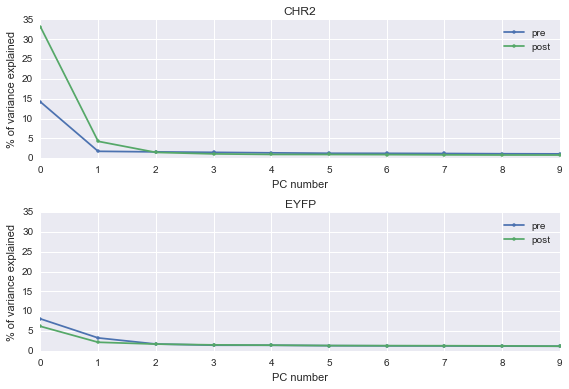

In [13]:
fig, ax = plt.subplots(2)
sortconditions = conditions
sortconditions.sort()
for c, condition in enumerate(sortconditions):
    for p, prepost in enumerate(pca_results_paths[condition].keys()):
        plot_variance_explained_per_pc(pca_results_paths[condition][prepost],fig,ax[c], label=prepost, numpcs=10)
    ax[c].set_title(condition, size='large')
    ax[c].legend(loc='upper right')
    
fig.tight_layout()
fig.show()

Save the above figure if needed

In [ ]:
figfile = os.path.join(results_directory,'Percent_variance_explained_by_pcs')
fig.savefig(figfile+'.png',format='png',dpi=300)
fig.savefig(figfile+'.pdf',format='pdf')

The next important thing to check is how the traces of activation in the PCA space look. If none of the PCs contain a strong stimulation evoked response, it is likely that there is no stimulation effect. Further, from the above plot of the fraction of variance explained, one can see that only the first 3 or so PCs are likely going to be representing anything interesting. Whether or not this representation is stimulation related is something that we will check by plotting the traces below.

It is a good idea to not save all the figure handles separately when plotting them. This will use a lot of memory and likely crash your computer. So save the figures immediately if you wish to save them into a directory so that you can scroll through the figures. Also, once the figures are saved, it's a good idea to clear all those handles so as to clear memory.


In [ ]:
for condition in conditions:
    for prepost in pca_results_paths[condition].keys():
        data_in_pcaspace = PCA_decomp(mean_data_for_condition[condition][prepost], 
                                      pca_results_paths[condition][prepost], 
                                      indices_for_windows)
        for pc in range(data_in_pcaspace.shape[0]):
            fig = plot_pc_traces(data_in_pcaspace, pc)
            fig.savefig(os.path.join(results_directory,condition,prepost,'PC%d_trace.png'%pc), format='png')
            fig.clf() #Use this if you don't want all figures displayed in the Jupyter notebook.

In [ ]:
reset_selective fig

Based on the plots of the PC traces, it is clear that there is one PC that represents the stimulation evoked response. There are also other PCs that represent interesting things but are likely noise-related.

The next important thing to check is how the PCA vectors look. This will instruct as to what voxels contribute to each PC. This way of looking at things is interesting to infer what voxels might be affected by the stimulation. Of course, an important caveat is that the PCA vector might not just represent stimulation evoked variability. We can check whether there's evidence to support this notion later by evaluating the PC vectors across multiple stimulations. If these vectors are similar across the multiple stimulations, then each PC vector likely represents mostly stimulation related variability.

As before, it is a good idea to not save all the figure handles separately when plotting them. This will use a lot of memory and likely crash your computer. So save the figures immediately if you wish to save them into a directory so that you can scroll through the figures. Also, once the figures are saved, it's a good idea to clear all those handles so as to clear memory.

In [ ]:
for condition in conditions:
    for prepost in pca_results_paths[condition].keys():
        data_in_pcaspace = PCA_decomp(mean_data_for_condition[condition][prepost], 
                                      pca_results_paths[condition][prepost],
                                      indices_for_windows)
        for pc in range(data_in_pcaspace.shape[0]):
            fig = plot_pc_vectors(pca_results_paths[condition][prepost], (numx, numy, numz), pc)
            fig.savefig(os.path.join(results_directory,condition,prepost,'PC%d_vector.png'%pc), format='png')
            fig.clf() #Use this if you don't want all figures displayed in the Jupyter notebook.

In [ ]:
reset_selective fig

Now that we know that the results are interesting, we might want to plot the first PC from both conditions on top of each other for a figure. This PC is selected further below as the PC representing the stimulation effect. This is Figure xx in the manuscript. This function is written below and we will call it immediately after the definition.

In [14]:
def calculate_df_Welch_ttest(x,
                             y):
    # This function calculates the degrees of freedom for Welch's t test.
    # This is not given as a result for the scipy function
    # x and y should be vectors
    nx = x.shape[0];ny = y.shape[0]
    df = (np.var(x)/nx+np.var(y)/ny)**2/((np.var(x)/nx)**2/(nx-1)+(np.var(y)/ny)**2/(ny-1))
    return df

def overlay_pc_traces_from_all_conditions(data_for_conditions, 
                                          pca_results_paths,
                                          colors_for_conditions,
                                          pc_of_interest, 
                                          indices_for_windows):
    # This function overlays corresponding PCs across all conditions on a single plot.
    # This is useful if one wants to compare the PC traces between both conditions
    # without each PC being normalized within itself. It only plots one PC at a time.
    # That PC is specified by pc_of_interest
    
    # Parameters:
    # data_for_conditions: The data from all conditions organized in a dictionary
    #                      on which the PCA was performed.
    # pca_results_paths  : Note that this should be a dictionary of the PCA results
    #                      paths for ALL conditions. This is different from the
    #                      variable pca_results_path which was used in earlier 
    #                      functions.
    # colors_for_conditions: A list specifying the colors for the conditions.
    # pc_of_interest     : Which PC number to plot. In our case, we will plot PC0
    #                      across both CHR2 and EYFP conditions. 
    # indices_for_windows: Calculated previously in the raw data visualization.
    
    # Returns: Figure handle for the plot
    
    trace_for_condition = np.nan*np.ones((2,2,indices_for_windows[-1]))
    conditions = data_for_conditions.keys()
    conditions.sort()
    
    for c, condition in enumerate(conditions):
        for p, prepost in enumerate(data_for_conditions[condition].keys()):
            dataforpca = data_for_conditions[condition][prepost]
            data_in_pcaspace = PCA_decomp(dataforpca,
                                          pca_results_paths[condition][prepost],
                                          indices_for_windows)
            temp = (data_in_pcaspace[pc_of_interest,:])
            # This makes sure that the mean value of the traces in the last 10s of
            # baseline are equal between all conditions.
            trace_for_condition[c,p,:] = temp-np.mean(temp[10:indices_for_windows[1]])
        
    normalization = np.amax(trace_for_condition)
    lowest = np.amin(trace_for_condition)
    ylimlow = lowest/normalization*1.05;ylimhigh = 1.05    
    
    ttestperiod = [25,35]
    (t, p) = stats.ttest_ind(trace_for_condition[0,1,ttestperiod[0]:ttestperiod[1]], 
                             trace_for_condition[0,0,ttestperiod[0]:ttestperiod[1]], equal_var=False)
    df = calculate_df_Welch_ttest(trace_for_condition[0,0,ttestperiod[0]:ttestperiod[1]], 
                             trace_for_condition[0,0,ttestperiod[0]:ttestperiod[1]])
    print 't-test results post-pre for ChR2: t(%f) = %.3f, p = %f'%(df,t,p)
    (t, p) = stats.ttest_ind(trace_for_condition[1,1,ttestperiod[0]:ttestperiod[1]], 
                             trace_for_condition[1,0,ttestperiod[0]:ttestperiod[1]], equal_var=False)
    df = calculate_df_Welch_ttest(trace_for_condition[0,0,ttestperiod[0]:ttestperiod[1]], 
                             trace_for_condition[0,0,ttestperiod[0]:ttestperiod[1]])
    print 't-test results post-pre for eYFP: t(%f) = %.3f, p = %f'%(df,t,p)
    
    fig, ax = plt.subplots()
    for c, condition in enumerate(conditions):
        for p, prepost in enumerate(data_for_conditions[condition].keys()):
            trace = trace_for_condition[c,p,:]/normalization
            if p==0:
                ax.plot(trace, '--', color=colors_for_conditions[c], label=condition+': '+prepost)
            elif p==1:
                ax.plot(trace, color=colors_for_conditions[c], label=condition+': '+prepost)
            """if c==0:
                for epochindex in range(1,indices_for_windows.shape[0]-1):
                    ax.plot(indices_for_windows[epochindex]*np.array([1, 1]), [ylimlow, ylimhigh], '--k', linewidth=1)"""
    ax.set_ylim([ylimlow, ylimhigh])
    ax.set_ylabel('Normalized PC signal (score)')
    ax.set_xlabel('Time (s)')
    ax.legend(loc='upper left')
    fig.tight_layout()
    return fig

t-test results post-pre for ChR2: t(18.000000) = 19.484, p = 0.000000
t-test results post-pre for eYFP: t(18.000000) = -0.660, p = 0.519142


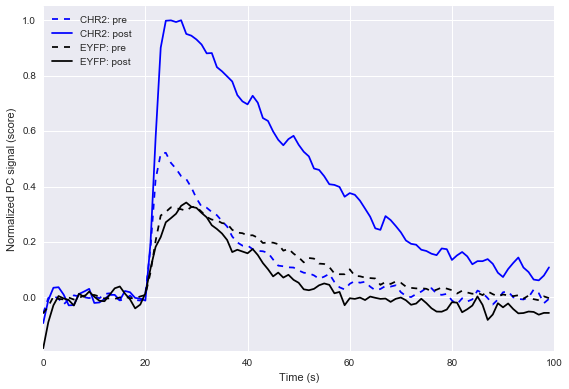

In [15]:
fig=overlay_pc_traces_from_all_conditions(mean_data_for_condition, 
                                          pca_results_paths,
                                          ['b','k'],
                                          0, 
                                          indices_for_windows)
#fig.savefig(os.path.join(results_directory, 'Overlaidtraces_CHR2_EYFP_Pre_Post.png'), format='png', dpi=300)
#fig.savefig(os.path.join(results_directory, 'Overlaidtraces_CHR2_EYFP_Pre_Post.pdf'), format='pdf')

A couple of last things to check for the PC vectors is

1. whether the PC weights represent stimulation evoked response, at least partially. To this end, we can make a scatter plot of PC weights and stimulation response either during the stimulation period or during the post stimulation period.

2. sorting raw voxel traces by PC weights. The function for this was written earlier as plot_traces_for_each_voxel()

In [16]:
def compare_pcweights_and_stimresponse(data,
                                       pca_results_paths,
                                       indices_for_windows, 
                                       colors_for_conditions,
                                       pc_of_interest=None, 
                                       periodofinterest='poststim'):
    # This function creates a scatter plot of the PC weights and stimulation response
    # for each voxel.
    
    # Parameters:
    # data_for_conditions: The data from all conditions organized in a dictionary
    #                      on which the PCA was performed.
    # pca_results_paths  : Note that this should be a dictionary of the PCA results
    #                      paths for ALL conditions. This is different from the
    #                      variable pca_results_path which was used in earlier 
    #                      functions.
    # indices_for_windows: Calculated previously in the raw data visualization.
    # pc_of_interest     : Which PC number to plot. In our case, we will plot PC0
    #                      across both CHR2 and EYFP conditions. 
    # colors_for_conditions: A list specifying the colors for the conditions.
    
    # Returns: Figure handle for the plot
    
    conditions = data.keys()
    conditions.sort()
    
    (numx,numy,numz,numt) = data[conditions[0]].shape

    poststimperiod = np.arange(indices_for_windows[2],indices_for_windows[3])
    stimperiod = np.arange(indices_for_windows[1],indices_for_windows[2])
    allrows = np.arange(numx*numy*numz) #useful for indexing all rows
    
    fig, ax=plt.subplots()
    for c, condition in enumerate(conditions):
        temp = np.reshape(data[condition], (numx*numy*numz, numt))
        
        if periodofinterest=='poststim':
            response_for_voxel = np.nanmean(temp[np.ix_(allrows,poststimperiod)], axis=1)
        elif periodofinterest=='stim':
            response_for_voxel = np.nanmean(temp[np.ix_(allrows,stimperiod)], axis=1)
            
        pca = joblib.load(pca_results_paths[condition])
        #Convert flattened voxels to the original tiling
        voxel_components = pca.components_.T
        if pc_of_interest is None:
            raise Exception('Specify which PC to compare')
        
        voxelweights = voxel_components[:, pc_of_interest]
        lm = sm.OLS(response_for_voxel, sm.add_constant(voxelweights)).fit()
        R2 = lm.rsquared
        temp = np.array([voxelweights.min(), voxelweights.max()]).T
        temp = sm.add_constant(temp)
        temppred = lm.predict(temp)
        
        ax.plot(voxelweights,
                response_for_voxel,
                '.' + colors_for_conditions[c], 
                label='%s, $R^2$=%.2f'%(condition,R2))
        
        ax.plot(temp[:,1],temppred, colors_for_conditions[c])
        
        ax.legend(loc='upper left')
        ax.set_xlabel('Weight of voxel to PC'+str(pc_of_interest))
        ax.set_ylabel("Mean response in the '%s' period"%(periodofinterest))
    
    return fig

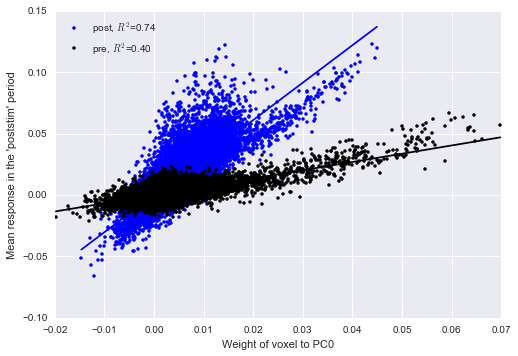

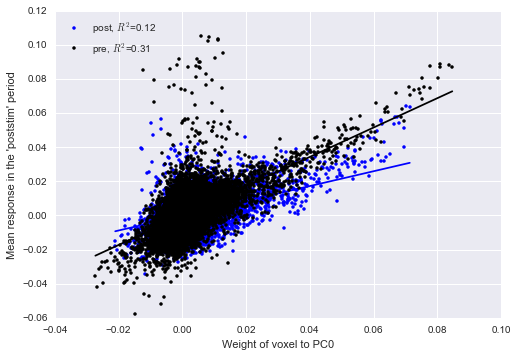

In [18]:
for condition in conditions:
    fig = compare_pcweights_and_stimresponse(mean_data_for_condition[condition],
                                       pca_results_paths[condition],
                                       indices_for_windows, 
                                       ['b','k'],
                                       pc_of_interest=0, 
                                       periodofinterest='poststim')

## Perform statistical tests on the data for evaluating voxels showing significant evoked responses

Our aim now is to interpret the brainwide pattern of response due to the stimulation. The primary aim of this section is to calculate the extent of voxels that show stimulation induced activity change.

The first approach to do this calculation will be to do a voxel-wise t-test on the response pattern to check how many voxels show a significant post-stimulation response. Of course, since we will be performing numerous independent statistical hypothesis testings (one for each voxel), we will have to correct for multiple comparisons. We will use the Benjamini-Hochberg FDR correction for this purpose.


In [19]:
def Benjamini_Hochberg_correction(vector_of_pvals,
                                  alpha = 0.05):
    # This function implements the BH FDR correction
    
    # Parameters:
    # Vector of p values from the different tests
    # alpha:significance level
    
    # Returns: Corrected p values. All the p values that are above the FDR threshold are set to 1. 
    #          Remaining p values are unchanged.
    sortedpvals = np.sort(vector_of_pvals)
    orderofpvals = np.argsort(vector_of_pvals)
    m = sortedpvals[np.isfinite(sortedpvals)].shape[0] #Total number of hypotheses
    for i in range(m):
        if sortedpvals[i] > (i+1)*alpha/m:
            k = i
            break
        elif i == m-1:
            k = m-1
        
    correctedpvals = vector_of_pvals
    correctedpvals[orderofpvals[k:]] = 1
    return correctedpvals

def voxels_showing_significant_t_values(data, 
                                        indices_for_windows,
                                        periodofinterest='poststim'):
    
    # This function extracts the voxels showing significant t values in a test between
    # the response during the periodofinterest and the baseline. For a voxel to be significant,
    # the t-tests for both instances of the periodofinterest must be significant wrt the
    # baseline. 
    
    # Parameters:
    # 1. data to calculate significant voxels from. Shape (num,numy,numz,numt)
    # 2. indices_for_windows
    # 3. Periodofinterest can be set to either 'poststim' (default) or 'stim'. But be aware
    #    that there might just be light evoked transient response in the stim period. So, we
    #    check for significant responses in the poststim period. This should be due to DA release.
    
    # Returns: 
    # 1. Significant voxels
    # 2. t test results for both conditions as a dictionary. For each condition, the results
    #    are arranged as a 4-column matrix with the 1st two columns representing the t-score
    #    and the FDR corrected p values respectively. The second two columns represent these values
    #    for the second instance of the periodofinterest.
    
    conditions = data.keys()
    conditions.sort()
    
    (numx,numy,numz,numt) = data[conditions[0]].shape
    
    significantvoxels_for_condition = {}
    ttestresults_for_condition = {}
    poststimperiod1 = np.arange(indices_for_windows[2],indices_for_windows[3])
    stimperiod1 = np.arange(indices_for_windows[1],indices_for_windows[2])
    baselineperiod = np.arange(indices_for_windows[1])
    
    
    for c, condition in enumerate(conditions):
        temp = np.reshape(data[condition], (numx*numy*numz, numt))

        ttestresults_per_voxel = np.nan*np.ones((numx*numy*numz,2)) 
        #contains t score and p value for periods associated with stim1
        for voxel in range(numx*numy*numz):
            baseline = temp[voxel,baselineperiod]
            if periodofinterest=='poststim':
                signal1 = temp[voxel, poststimperiod1]
            elif periodofinterest=='stim':
                signal1 = temp[voxel, stimperiod1]
            ttestresults_per_voxel[voxel,:2] = stats.ttest_ind(signal1, baseline, equal_var=False)
        
        pvals1 = Benjamini_Hochberg_correction(ttestresults_per_voxel[:,1]) #FDR corrected pvals for period 1
        ttestresults_per_voxel[:,1] = pvals1
        significantvoxels = np.logical_and(pvals1<=0.05, ttestresults_per_voxel[:,0]>0)
        significantvoxels = np.reshape(significantvoxels, (numx,numy,numz))
        significantvoxels_for_condition[condition] = significantvoxels
        ttestresults_for_condition[condition] = np.reshape(ttestresults_per_voxel,(numx,numy,numz,2))
        
        print 'Total number of significant voxels for %s = %d' % (condition, np.sum(significantvoxels))
        
    return significantvoxels_for_condition, ttestresults_for_condition

In [20]:
significantvoxels_for_condition = {}

In [ ]:
significantvoxels_for_condition['ttest']={}
ttestresults = {}
for condition in conditions:
    significantvoxels_for_condition['ttest'][condition], ttestresults[condition] = voxels_showing_significant_t_values(mean_data_for_condition[condition],
                                                                                             indices_for_windows)

The second approach will be calculate how many voxels contribute significantly to the principal components showing stimulation evoked post-stimulation response. To this end, we will select PCs that satisfy the following criteria: a. traces show significant t tests between both poststimulation periods and baseline, b. both post-stimulation periods show a reducing trace. The second criterion is to ensure that traces that just show a monotonous pattern throughout the session are not selected. The remaining steps are as follows:

1. For these PCs, find the voxels that significantly contribute to the PC.

2. Categorize these significant voxels based on the ROI they correspond to and rank ROIs based on their contribution to the PCs.

3. Test whether the significant PC due to the first stimulation is similar to the one due to the second stimulation

In [21]:
def select_pcs_with_significant_evoked_responses(data,
                                                 pca_results_paths,
                                                 indices_for_windows,
                                                 periodofinterest='poststim'):
    significantpcs_for_condition = {}
    ttestresults_for_condition = {}
    conditions = data.keys()
    conditions.sort()
    
    poststimperiod1 = np.arange(indices_for_windows[2],indices_for_windows[3])
    stimperiod1 = np.arange(indices_for_windows[1],indices_for_windows[2])
    baselineperiod = np.arange(indices_for_windows[1])
    
    for condition in conditions:
        datainpcaspace = transform_from_loadedpca(data[condition], pca_results_paths[condition])
        numpcs = datainpcaspace.shape[0]
        ttestresults_per_pc = np.nan*np.ones((numpcs,2))       

        
        poststimslope = np.nan*np.ones((numpcs,))#slope of post stim response for stim1
        
        for pc in range(numpcs):
            baseline = datainpcaspace[pc,baselineperiod]
            if periodofinterest=='poststim':
                signal1 = datainpcaspace[pc, poststimperiod1]
            elif periodofinterest=='stim':
                signal1 = datainpcaspace[pc, stimperiod1]
            ttestresults_per_pc[pc,:2] = stats.ttest_ind(signal1, baseline, equal_var=False)
            
            trace = datainpcaspace[pc, poststimperiod1].T
            time = np.arange(trace.shape[0]).T
            time = sm.add_constant(time)
            lm = sm.OLS(trace, time).fit()
            poststimslope[pc] = lm.params[1]
            
        
        pvals1 = Benjamini_Hochberg_correction(ttestresults_per_pc[:,1]) #FDR corrected pvals for period 1
        
        ttestresults_per_pc[:,1] = pvals1
                
        #Calculate PCs with significant post stim response that is in the correct direction
        tempsignificantpcs1 = np.logical_and(pvals1<=0.05, ttestresults_per_pc[:,0]>0)
        #Calculate PCs with decreasing post stim response trace
        tempsignificantpcs2 = poststimslope<0
        #Select PCs that show both of the above
        significantpcs = np.where(np.logical_and(tempsignificantpcs1,tempsignificantpcs2))
        
        significantpcs_for_condition[condition] = significantpcs
        ttestresults_for_condition[condition] = ttestresults_per_pc
    return significantpcs_for_condition, ttestresults_for_condition
    
def identify_significant_voxels_per_significant_pc(data,
                                                   pca_results_paths,
                                                   significantpcs_for_condition):
    conditions = data.keys()
    conditions.sort()
    (numx,numy,numz,numt) = data[conditions[0]].shape
    
    significantvoxels_for_condition = {}
    
    for condition in conditions:
        flatteneddata = np.reshape(data[condition],(numx*numy*numz,numt))
        datainpcaspace = transform_from_loadedpca(data[condition],
                                                  pca_results_paths[condition])
        
        significantpcs = significantpcs_for_condition[condition][0]
        significantvoxels_per_pc = {}
        corrresults_per_voxel = np.nan*np.ones((numx*numy*numz,2)) # R2, p value for pearson's R
        for pc in significantpcs:
            pcscore = datainpcaspace[pc,:]
            for voxel in range(numx*numy*numz):
                datapervoxel = flatteneddata[voxel,:]
                corrresults_per_voxel[voxel,:] = stats.pearsonr(pcscore,datapervoxel)

                #Set voxels outside of the brain to nan
                if np.all(datapervoxel==0):
                    corrresults_per_voxel[voxel,:] = np.nan*np.ones((corrresults_per_voxel.shape[1],))
                
            pvals = Benjamini_Hochberg_correction(corrresults_per_voxel[:,1])
            significantvoxels = pvals<=0.05
            significantvoxels = np.reshape(significantvoxels, (numx,numy,numz))
            significantvoxels_per_pc[str(pc)] = significantvoxels
            
            print 'Total number of significant voxels for %s; PC%d = %d' % (condition, pc, np.sum(significantvoxels))
            
        significantvoxels_for_condition[condition] = significantvoxels_per_pc
    return significantvoxels_for_condition

In [22]:
significantvoxels_for_condition['PCA']={}
significantpcs_for_condition={}
for condition in conditions:    
    print 'Processing %s'%condition
    significantpcs_for_condition[condition], ignore = select_pcs_with_significant_evoked_responses(mean_data_for_condition[condition], 
                                                                                        pca_results_paths[condition],
                                                                                        indices_for_windows,
                                                                                        periodofinterest='stim')
    significantvoxels_for_condition['PCA'][condition] = identify_significant_voxels_per_significant_pc(
                                                                                    mean_data_for_condition[condition],
                                                                                    pca_results_paths[condition],
                                                                                    significantpcs_for_condition[condition])

Processing CHR2
Total number of significant voxels for post; PC0 = 18967
Total number of significant voxels for pre; PC0 = 7376
Processing EYFP
Total number of significant voxels for post; PC0 = 3685
Total number of significant voxels for pre; PC0 = 3791


## Import pre-defined ROIs and visualize them

In [23]:
def draw_atlas(ROI_and_atlas_handle,
               fig,
               axs):
    # Plots the T2 weighted atlas. It returns the fig and axes objects that you can then use to layer
    # additional plots on top.

    #Parameters:
    #   1. File handle to the HDF5 file containing the atlas.
    #   2. Handle to a figure on which the atlas will be drawn.
    #   3. Axes handles of that figure to each subplot
    
    # Returns: Figure handle for the plot, axes handles, total number of voxels in the brain    
    
    
    atlas = np.array(ROI_and_atlas_handle['T2 atlas']).astype(float)
    total_voxels_in_brain = np.sum(atlas>0)
    lowthreshold = 1000 #This is the threshold below which T2 signals are thresholded out of the image
    cmin = lowthreshold
    cmax = np.amax(atlas)
    
    
    (numx, numy, numz) = atlas.shape
    flat_atlas = np.reshape(atlas,(numx*numy*numz,))
    
    norm = colors.Normalize(vmin=cmin, vmax=cmax)
    m = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('Greys_r'))
    colors_for_voxels = m.to_rgba(flat_atlas)
    colors_for_voxels[flat_atlas<=lowthreshold,3]=0 #Set areas outside of brain as transparent
    colors_for_voxels = np.reshape(colors_for_voxels,(numx,numy,numz,4))
    for zplane in range(0,numz):
        ax = axs.flat[zplane]
        ax.imshow(np.swapaxes(colors_for_voxels[:,:,zplane,:],0,1),interpolation='bilinear')
        #ax.imshow(np.swapaxes(atlas[:,:,zplane],0,1),interpolation='bilinear')
        #You have to swap the axes since the x axis is arranged across rows and y, columns.
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    return fig, axs, total_voxels_in_brain

def layer_all_rois(ROI_and_atlas_handle,
                   fig,
                   axs):
    # Layers the ROIs on top of the T2 weighted atlas that has already been plotted.

    #Parameters:
    #   1. File handle to the HDF5 file containing all the ROIs and the atlas.
    #   2. Handle to the figure on which the atlas was be drawn.
    #   3. Axes handles of that figure to each subplot
    
    # Returns: Figure handle for this plot and another figure handle for the legend
    
    listofrois = ROI_and_atlas_handle.keys()
    listofrois.remove('T2 atlas')
    listofrois = [str(a) for a in listofrois]
    listofrois.sort(key=str.lower)
    numrois = len(listofrois)
    colors_for_rois = np.random.rand(numrois,3) #RGB values. Will be converted to RGBA below
    temp = np.ones((colors_for_rois.shape[0], colors_for_rois.shape[1]+1))
    temp[:,:-1] = colors_for_rois
    colors_for_rois = temp #RGBA values
    ROI0 = ROI_and_atlas_handle[listofrois[0]]
    (numx,numy,numz) = ROI0.shape
    mergedROIs = np.zeros((numx,numy,numz,4))

    for roinumber, ROIname in enumerate(listofrois):
        ROI = np.array(ROI_and_atlas_handle[ROIname])
        ROIflip = ROI[:,::-1,:] #The ROI is only unilateral. It is flipped and added to get the full ROI
        ROI = np.add(ROI,ROIflip)
        ROIwithcolors = np.tile(np.expand_dims(ROI,axis=3), (1,1,1,4))+0.0
        temp = np.reshape(ROIwithcolors, (numx*numy*numz,4))
        temp = temp*colors_for_rois[roinumber,:]  
        ROIwithcolors = np.reshape(temp,(numx,numy,numz,4))
        mergedROIs += ROIwithcolors

    mergedROIs[mergedROIs[:,:,:,0]==0] = np.array([1,1,1,0]) #set non-ROI pixels as transparent
    for zplane in range(0,numz):
        ax = axs.flat[zplane]
        ax.imshow(mergedROIs[:,:,zplane,:],interpolation='bilinear')
        #Do not swap axes for ROIs. They are already flipped.
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout()

    def make_legend_for_ROIs():
        fig1, ax1 = plt.subplots(1,1,figsize=(10,10))
        fig1.set_facecolor('w')
        fig1.set_frameon(False)
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)
        recth = 0.05
        rectw = 0.05

        numcolsforlabels = 6
        numrowsforlabels = np.ceil((numrois+0.0)/numcolsforlabels)
        grid = np.mgrid[0.1:0.9:numrowsforlabels/1j, 0.9:0.3:numcolsforlabels/1j].reshape(2, -1).T

        def label(xy, text):
            y = xy[1] - 1.7*recth  # shift y-value for label so that it's below the artist
            x = xy[0] - rectw/2  # shift x-value for label so that it's centered with the artist
            newtext = re.sub("(.{12})", "\\1\n", text, 0, re.DOTALL) #split names longer than 12 characters into newlines
            ax1.text(x, y, newtext, ha="center", size=10)

        for roinumber, ROIfile in enumerate(listofrois):
            ROIname = os.path.splitext(ROIfile)[0]
            ROIbox = mpatches.Rectangle(grid[roinumber]-[recth,rectw],recth,rectw, color=(colors_for_rois[roinumber]),ec='none')
            ax1.add_patch(ROIbox)
            label(grid[roinumber], ROIname)

        return fig1
    
    fig1 = make_legend_for_ROIs()
    
    return fig, fig1

Plot the ROIs on the atlas to visualize them

Total number of voxels in the brain is: 35182


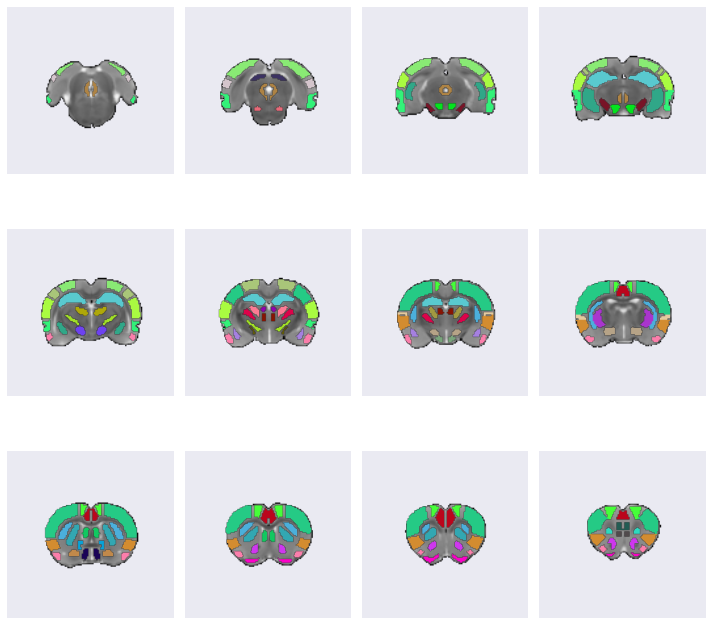

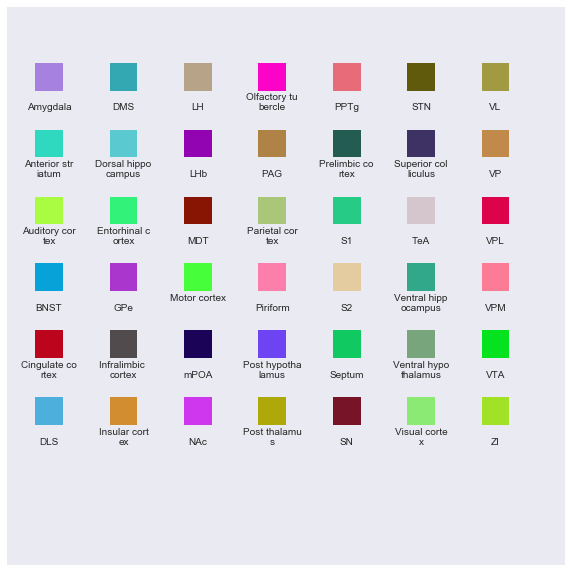

In [24]:
#Plot masks of named ROIs

ROI_and_atlas_file = os.path.join(os.path.join(working_directory, 'ROIs_and_atlas.hdf5'))

ROI_and_atlas_handle = h5py.File(ROI_and_atlas_file,'r')

fig, axs = plt.subplots(3, 4, figsize=(10,10))
fig, axs, total_voxels_in_brain = draw_atlas(ROI_and_atlas_handle, fig, axs)
np.random.seed(seed=18)
fig, fig1 = layer_all_rois(ROI_and_atlas_handle, fig, axs)

print 'Total number of voxels in the brain is: %d' %total_voxels_in_brain

In [ ]:
fig.savefig(os.path.join(working_directory, 'ROIs.png'), format='png', dpi=300, transparent=True)
fig1.savefig(os.path.join(working_directory, 'ROIlegends.png'), format='png', dpi=300, transparent=True)
fig.savefig(os.path.join(working_directory, 'ROIs.pdf'), format='pdf', transparent=True)
fig1.savefig(os.path.join(working_directory, 'ROIlegends.pdf'), format='pdf', transparent=True)

## Layer the significant voxels back on to the atlas and map the contribution of different ROIs

In [45]:
def extract_pca_vectors_for_condition(pca_results_paths,
                                      (numx,numy,numz)):
    # This function calculates the PC vectors for the given pca paths across all conditions. 
    # Useful for mapping the weights for the significant voxels.
    
    #Parameters:
    # PCA results paths
    # Spatial shape
    
    #Returns: PCA vectors
    conditions = pca_results_paths.keys()
    pca_vectors = {}
    for condition in conditions:
        pca = joblib.load(pca_results_paths[condition])
        #Convert flattened voxels to the original tiling
        pca_vectors[condition] = np.reshape(pca.components_.T, (numx,numy,numz,pca.components_.shape[0]))
    return pca_vectors

def layer_significant_voxels(fig,
                             axs,
                             significant_voxels,
                             voxel_weights,
                             colorbarlabel,
                             sign=None):
    # This function layers all the significant voxels on top of the atlas. 
    
    #Parameters:
    # 1. figure handle to the figure in which the atlas was drawn.
    # 2. axes handles to the above figure.
    # 3. the significant voxels in the brain.
    # 4. voxel_weights: what is to be plotted for each significant voxel.
    #                  In the case of 'ttest', this will be the t score
    #                  In all other cases, this will be PC weights
    # 5. what should be the label on the colorbar?
    # 6. sign: if specified, the voxel weights will be multiplied by this number.
    #          Otherwise, it will be set to the maximum voxel weight so as to
    #          normalize. This should be set to 1 for 'ttest' case and None for
    #          the other cases
    
    #Returns: Figure handle
    
    (numx, numy, numz) = voxel_weights.shape
    
    flat_significant_voxels = np.reshape(significant_voxels,(numx*numy*numz,))
    flat_voxel_weights=np.nan_to_num(np.reshape(voxel_weights, (numx*numy*numz,)))
    if sign is None:
        sign = np.sign(flat_voxel_weights[np.argmax(np.abs(flat_voxel_weights))])
    flat_voxel_weights=sign*flat_voxel_weights
    temp = (flat_voxel_weights[flat_significant_voxels==1])
    
    if colorbarlabel != 't score' and temp.shape[0]>0:
        normalization_of_weight = np.amax(temp)
    else:
        normalization_of_weight = 1
        
    if temp.shape[0]>0:
        cmin = np.amin(temp)/normalization_of_weight
        cmax = np.amax(temp)/normalization_of_weight
    else:
        cmin = 0
        cmax = 1
        
    norm = colors.Normalize(vmin=cmin, vmax=cmax)
    m = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('OrRd'))
    colors_for_voxels = m.to_rgba(flat_voxel_weights/normalization_of_weight)
    colors_for_voxels[flat_significant_voxels==0,3]=0
    colors_for_voxels = np.reshape(colors_for_voxels,(numx,numy,numz,4))
    for zplane in range(0,numz):
        ax = axs.flat[zplane]
        ax.imshow(np.swapaxes(colors_for_voxels[:,:,zplane,:],0,1),interpolation='bilinear')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    cbar_ax = fig.add_axes([0.9, 0.3, 0.02, 0.4])
    cb = colorbar.ColorbarBase(cbar_ax, cmap=plt.get_cmap('OrRd'), norm=norm, spacing='proportional', format='%.2f')
    cb.set_label(colorbarlabel)
    
    #fig.tight_layout()        
    fig.show()
    return fig


Plot significant voxels from the ttest case

In [ ]:
conditions.sort()
for condition in conditions:
    for prepost in pca_results_paths[condition].keys():
        fig, axs = plt.subplots(3, 4, figsize=(10,10))
        fig, axs, total_voxels_in_brain = draw_atlas(ROI_and_atlas_handle,fig, axs)
        fig = layer_significant_voxels(fig,
                                       axs,
                                       significantvoxels_for_condition['ttest'][condition][prepost],
                                       ttestresults[condition][prepost][:,:,:,0],
                                       colorbarlabel = 't score',
                                       sign=1)
        fig.suptitle(condition+prepost)

Plot significant voxels based on PCA for the whole trace

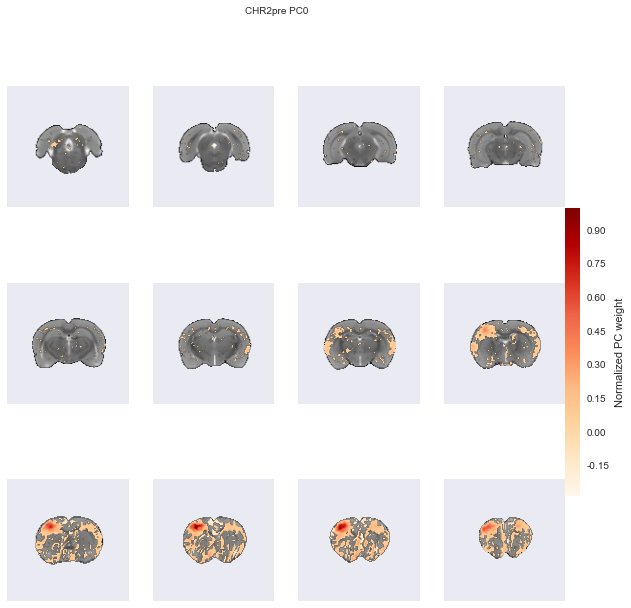

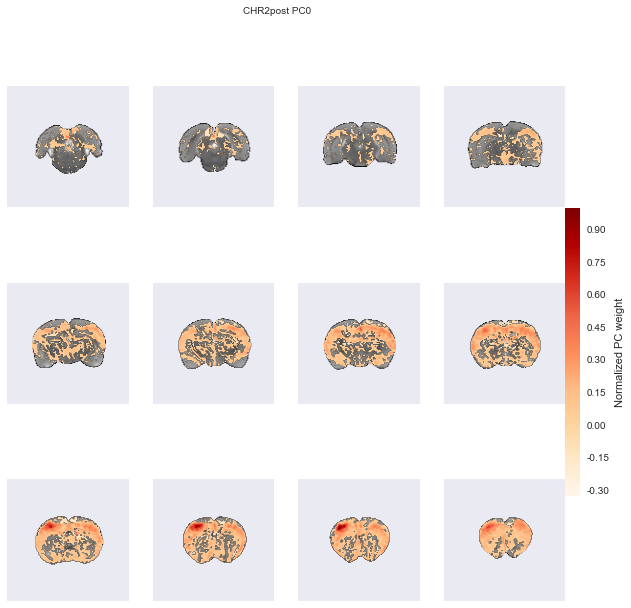

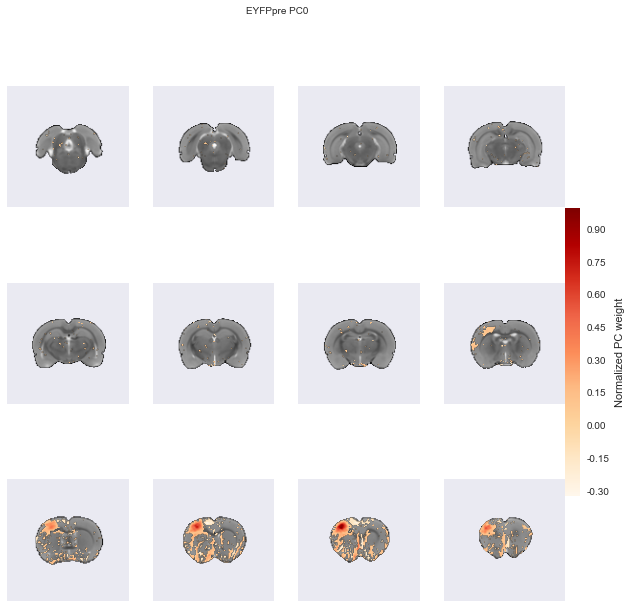

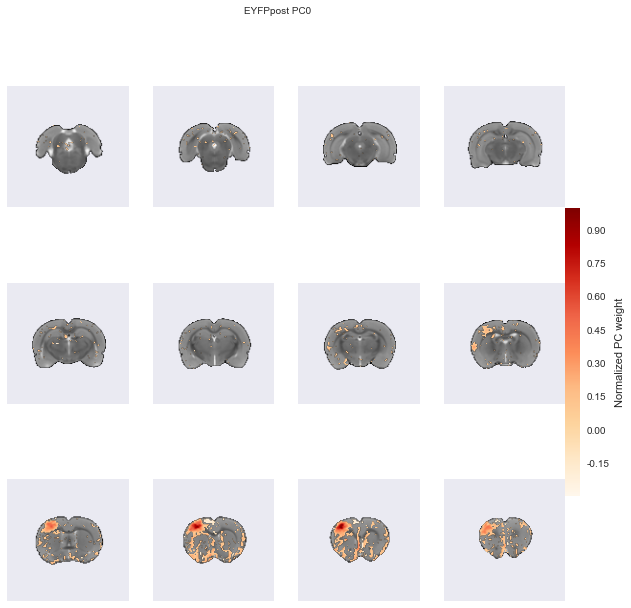

In [26]:
voxel_components_for_condition = {}
for condition in conditions:
    voxel_components_for_condition[condition] = extract_pca_vectors_for_condition(pca_results_paths[condition],
                                      (numx,numy,numz))
    for prepost in pca_results_paths[condition].keys():    
        significant_pcs = significantvoxels_for_condition['PCA'][condition][prepost].keys() 
        for pc in significant_pcs:
            fig, axs = plt.subplots(3, 4, figsize=(10,10))
            fig, axs, total_voxels_in_brain = draw_atlas(ROI_and_atlas_handle,fig, axs)
            fig = layer_significant_voxels(fig,
                                           axs,
                                           significantvoxels_for_condition['PCA'][condition][prepost][pc],
                                           voxel_components_for_condition[condition][prepost][:,:,:,int(pc)],
                                           colorbarlabel = 'Normalized PC weight')
            fig.suptitle(condition+prepost+' PC'+pc)
            fig.savefig(os.path.join(results_directory, 'significantvoxels_'+condition+prepost+' PC'+pc+'.png'),
                       format = 'png',
                       dpi = 300)
            fig.savefig(os.path.join(results_directory, 'significantvoxels_'+condition+prepost+' PC'+pc+'.pdf'),
                       format = 'pdf')

Plot the significant voxels for the GLM analysis done separately. These results are stored in GLMresults.hdf5. The model used for the GLM is described in the manuscript.

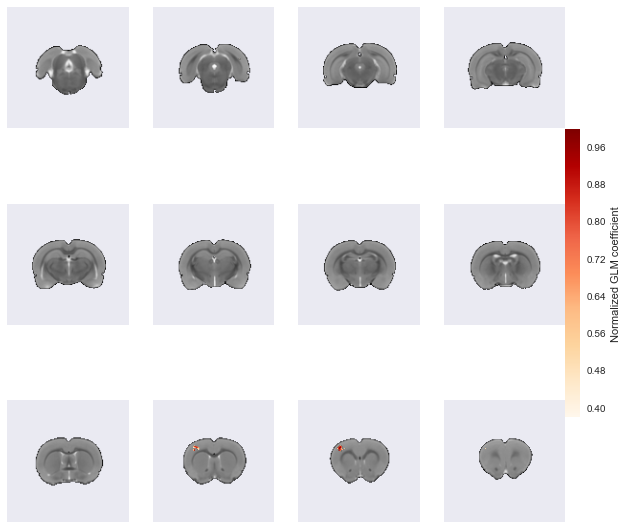

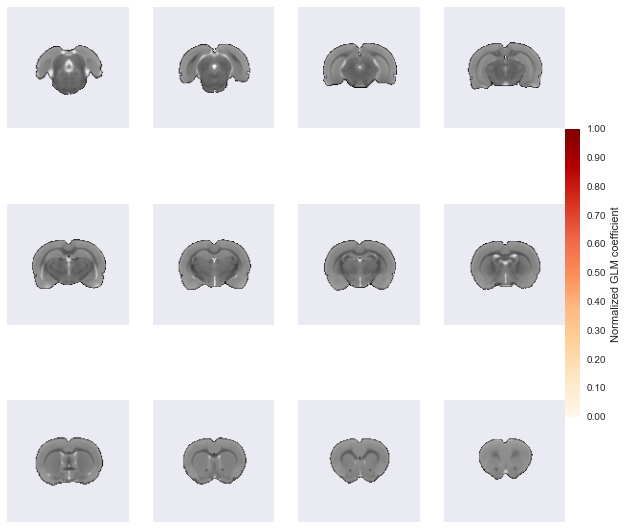

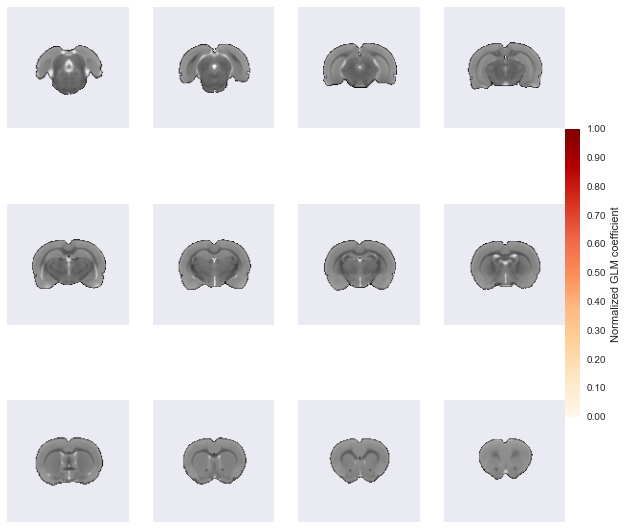

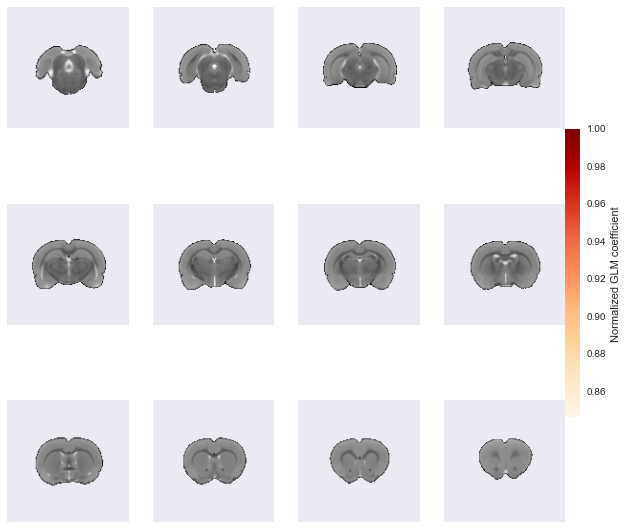

In [53]:
significantvoxels_for_condition['GLM']={}
GLMresultshandle = h5py.File(os.path.join(working_directory, 'GLMresults.hdf5'),'a')
freqofinterest = '09'
conditions.sort()
for condition in conditions:
    significantvoxels_for_condition['GLM'][condition] = {}
    for prepost in pca_results_paths[condition].keys():
        GLMresults = np.array(GLMresultshandle['paw_stimulation'][condition][freqofinterest][prepost])
        significantvoxels = GLMresults!=0
        significantvoxels_for_condition['GLM'][condition][prepost] = significantvoxels
        fig, axs = plt.subplots(3, 4, figsize=(10,10))
        fig, axs, total_voxels_in_brain = draw_atlas(ROI_and_atlas_handle,fig, axs)
        fig = layer_significant_voxels(fig,
                                       axs,
                                       significantvoxels,
                                       GLMresults,
                                       colorbarlabel = 'Normalized GLM coefficient')
        figfile = os.path.join(results_directory, 'significantvoxels_GLM_%s_%sHz_%s'%(condition, freqofinterest, prepost))
        fig.savefig(figfile+'.pdf',format='pdf', transparent=True)
        fig.savefig(figfile+'.png',format='png', dpi=300, transparent=True)

Map the significant voxels back to the ROIs

In [27]:
def map_voxels_to_ROIs(significant_voxels):
    listofrois = ROI_and_atlas_handle.keys()
    listofrois.remove('T2 atlas')
    listofrois = [str(a) for a in listofrois]
    numrois = len(listofrois)
    number_of_voxels_in_roi = np.nan*np.ones((numrois,1))#Total number of voxels in ROI
    number_of_significant_voxels_in_roi = np.nan*np.ones((numrois,1))

    for roinumber, ROIname in enumerate(listofrois):
        ROI = np.array(ROI_and_atlas_handle[ROIname])
        ROIflip = ROI[:,::-1,:]
        ROI = np.add(ROI,ROIflip)
        number_of_voxels_in_roi[roinumber] = np.sum(ROI)
        number_of_significant_voxels_in_roi[roinumber] = np.sum(np.multiply(ROI, significant_voxels))
        
    data = {}
    data['rois'] = listofrois
    data['Total voxels'] = number_of_voxels_in_roi
    data['Significant voxels'] = number_of_significant_voxels_in_roi
    return data
    
def map_voxels_to_ROIs_for_significantpcs(significantvoxels_for_condition):
    conditions = significantvoxels_for_condition.keys()
    conditions.sort()
    ROIcounts_for_condition = {}
    for condition in conditions:
        significant_pcs = significantvoxels_for_condition[condition].keys()
        ROIcounts_for_pc = {}
        for pc in significant_pcs:
            temp=np.swapaxes(significantvoxels_for_condition[condition][pc],0,1)
            ROIcounts = map_voxels_to_ROIs(temp)
            ROIcounts_for_pc[pc] = ROIcounts
        ROIcounts_for_condition[condition] = ROIcounts_for_pc
    return ROIcounts_for_condition

In [28]:
ROIcounts_for_condition = {}
ROIcounts_for_condition['PCA'] = {}
for condition in conditions:
    ROIcounts_for_condition['PCA'][condition] = map_voxels_to_ROIs_for_significantpcs(significantvoxels_for_condition['PCA'][condition])

In [42]:
def save_roicounts_csv(ROIcounts):
    #Save all the ROI counts for all cases
    def extract_and_save(data, condition, periodlabel, prepost, sortorder=None, label=''):
        significant_voxels = data['Significant voxels']
        total_voxels = data['Total voxels']
        listofrois = [a.split('.')[0] for a in data['rois']]
        fraction_voxels = np.nan_to_num(np.divide(significant_voxels, total_voxels))
        df = pd.DataFrame(np.column_stack((listofrois, 
                                           total_voxels,
                                           significant_voxels)),
                          columns=['ROIs','Total voxel count', 'Significant voxel count'])
        df.insert(3, 'Fraction', fraction_voxels)
        if sortorder is None:
            sorteddf= df.sort_values(by=['Fraction','Total voxel count'], ascending=False)
        else:
            sorteddf = df.loc[sortorder]
        sortorder = sorteddf.index.values
        sorteddf.to_csv(os.path.join(results_directory,
                                     'ROIs showing most significant voxels_%s%s_%s_%s.csv'%(periodlabel, label, condition, prepost)))
        return sorteddf, sortorder
            
    periodlabels = ROIcounts.keys()
    colorlist = [(0.26, 0.38, 0.28), (0.56, 0.81, 0.45)]
    sortedlistofrois = {}
    for condition in conditions:
        sortorder=None
        fig, ax = plt.subplots()
        for periodlabel in periodlabels: 
            #for condition in ROIcounts[periodlabel].keys():
            prepostkeys = ROIcounts[periodlabel][condition].keys()
            prepostkeys.sort()
            #prepostkeys = prepostkeys[::-1]
            for prepost in prepostkeys:
                if periodlabel=='ttest':
                    sorteddf, sortorder = extract_and_save(ROIcounts[periodlabel][condition][prepost], condition, periodlabel)
                else:
                    for pc in ROIcounts[periodlabel][condition][prepost].keys():
                        sorteddf, sortorder = extract_and_save(ROIcounts[periodlabel][condition][prepost][pc], 
                                                    condition, periodlabel, prepost, sortorder=sortorder, label='_pc%s'%(pc))

                        if prepost=='pre':
                            color = colorlist[0]
                        else:
                            color = colorlist[1]
                            sortedlistofrois[condition] = [ROIcounts[periodlabel][condition][prepost][pc]['rois'][i] for i in sortorder]
                        roiplot = sns.barplot(x="ROIs", y="Fraction", color=color, data=sorteddf, ax=ax, 
                                              label=condition+': '+prepost)
                        for item in roiplot.get_xticklabels():
                            item.set_rotation(90)
                        ax.set_ylim([0,1])
                        roiplot.set_ylabel("Fraction of voxels that are significant")
                        fig.tight_layout()

        ax.legend(loc='upper right')
        fig.savefig(os.path.join(results_directory,'ROIs showing most significant voxels_'+condition+'.png'), format='png', dpi=300)
        fig.savefig(os.path.join(results_directory,'ROIs showing most significant voxels_'+condition+'.pdf'), format='pdf')
    return sortedlistofrois

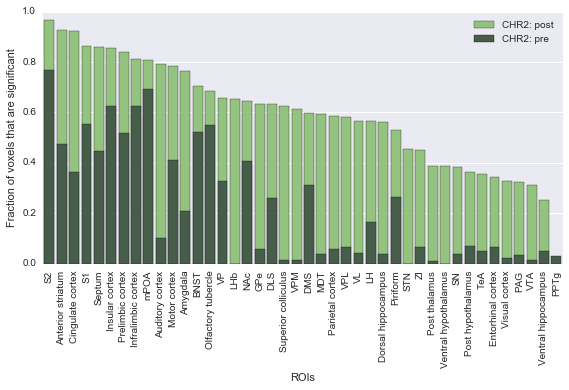

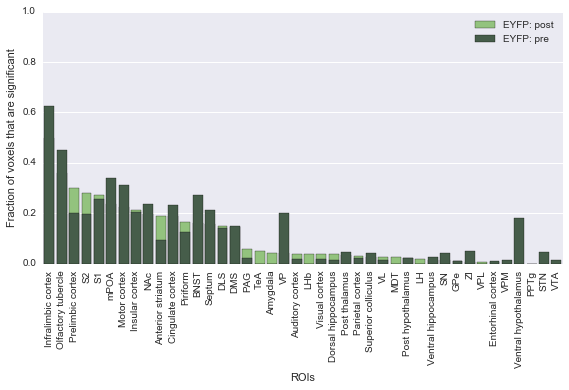

In [43]:
sortedlistofrois = save_roicounts_csv(ROIcounts_for_condition)

An important caveat of the sorting of ROIs above is that the actual magnitude of response in any voxel or ROI is not shown.

At this point, one may wish to see how this analysis would have looked if the average trace of each ROI was calculated. Of course, one extremely important caveat associated with this is that if only a few voxels within an ROI show a substantial response, then the average response of the ROI may still not be much. The benefit of the previous analysis is that it is entirely voxel-by-voxel and hence, the even if only a few voxels showed significant responses, those can be extracted.

The code is below is self-explanatory. So comments are not presented.

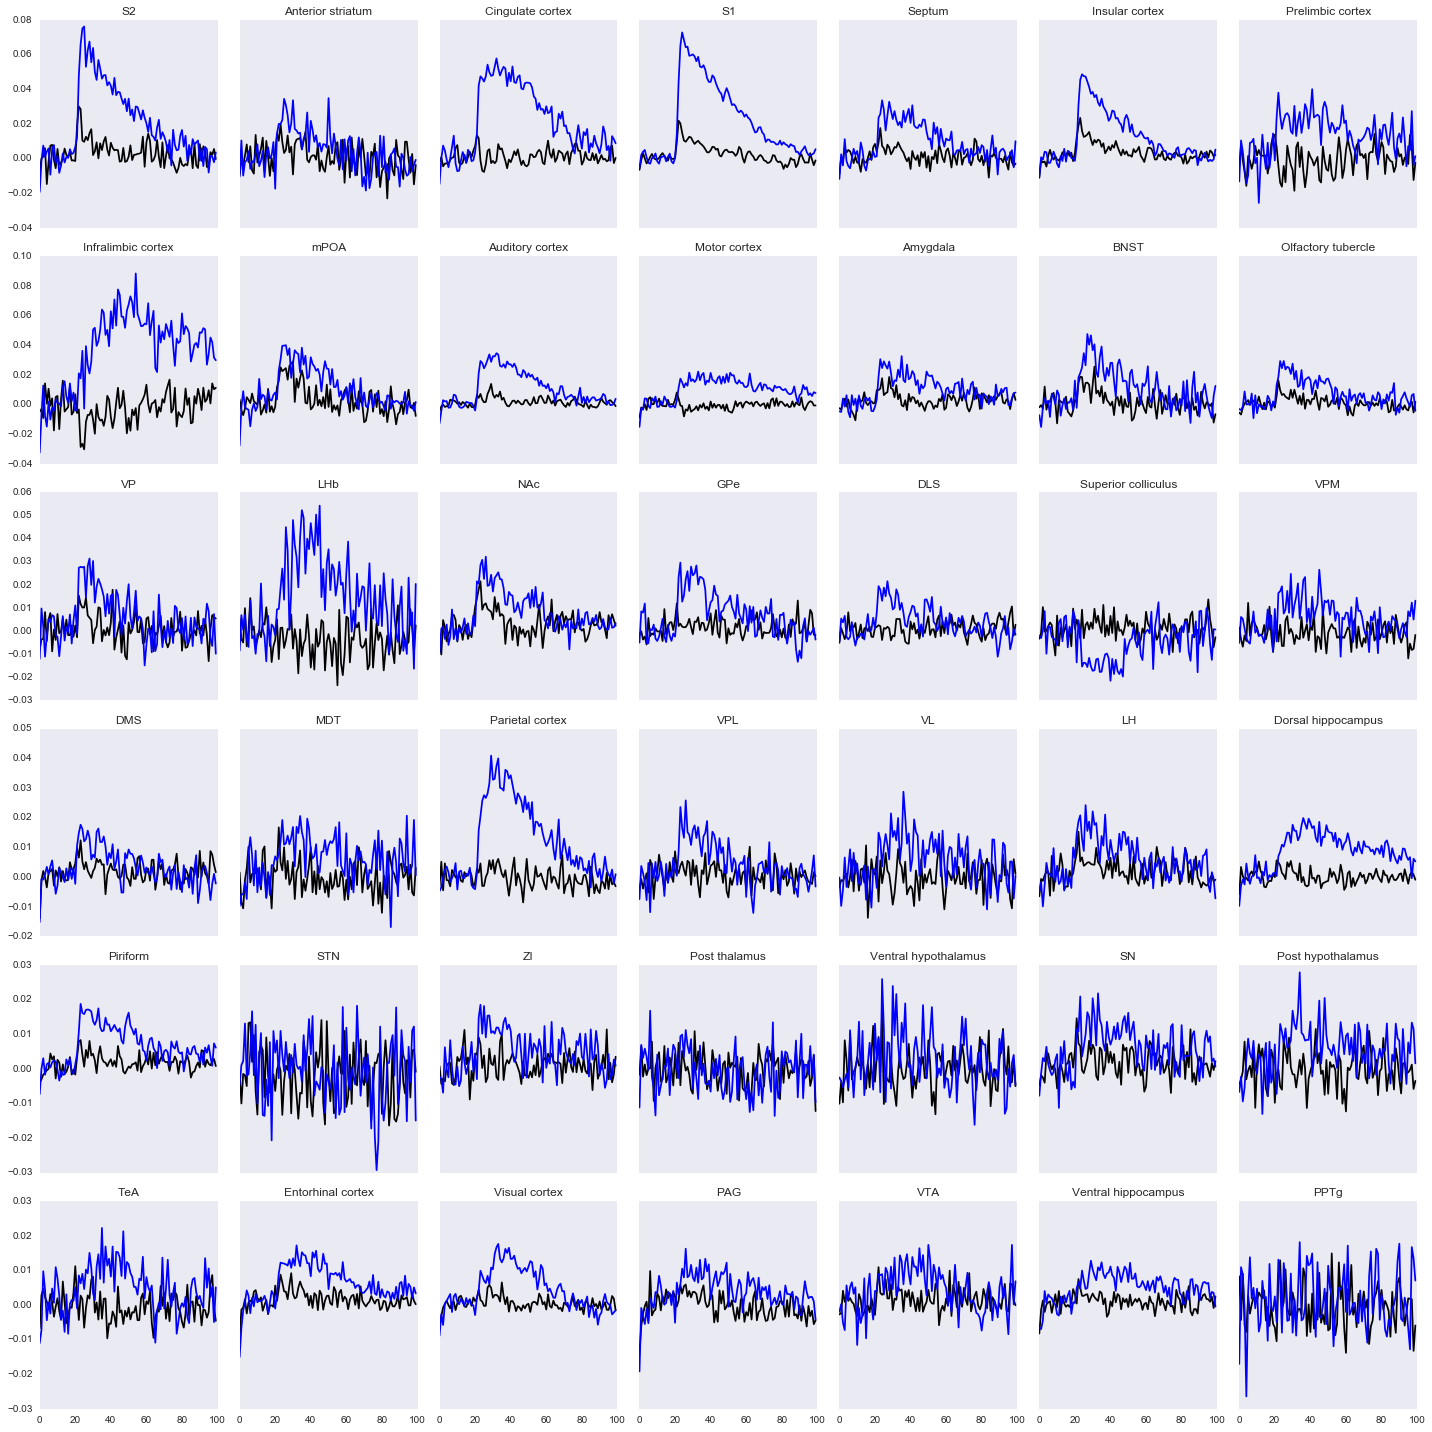

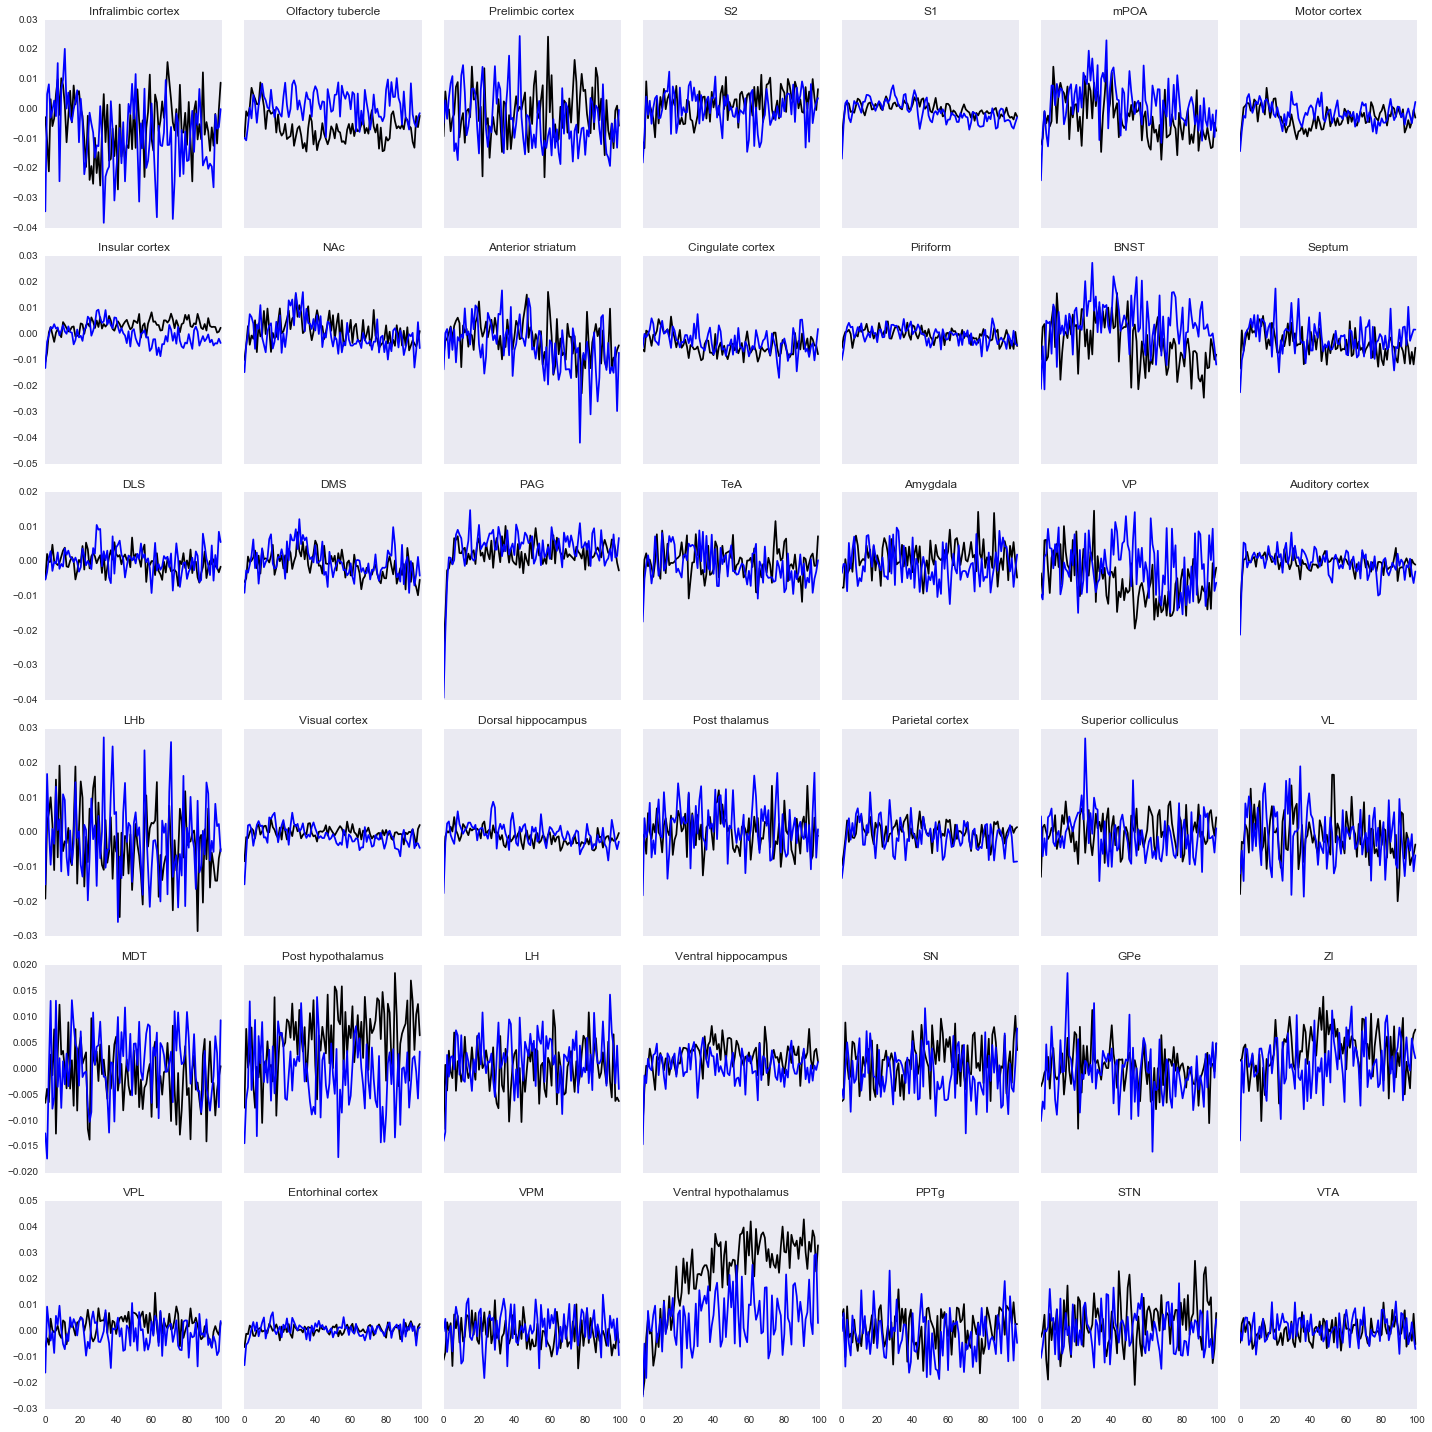

In [44]:
def plot_signal_for_ROI(data, ROI, fig, ax, color, ROIname):
    numt = data.shape[3]
    data_for_ROI = np.nan*np.ones((numt,))
    nanROI = ROI; nanROI[nanROI==0]=np.nan
    for t in range(numt):
        data_for_ROI[t] = np.nanmean(np.multiply(np.swapaxes(data[:,:,:,t],0,1), ROI))    
    ax.plot(data_for_ROI, color=color)
    ax.set_title(ROIname)
    ax.grid(b=False)  
    return fig

def plot_signal_for_all_ROIs(data, color, fig, axs, sortedlistofrois):
    for r, ROIname in enumerate(sortedlistofrois):
        ROI = np.array(ROI_and_atlas_handle[ROIname]).astype(float)
        fig = plot_signal_for_ROI(data, ROI, fig, axs.flat[r], color, ROIname)
    return fig
    
ROI_and_atlas_file = os.path.join(os.path.join(working_directory, 'ROIs_and_atlas.hdf5'))

ROI_and_atlas_handle = h5py.File(ROI_and_atlas_file,'r')
conditions = mean_data_for_condition.keys()

conditions.sort()
for condition in conditions:
    fig, axs = plt.subplots(6,7, sharex='col', sharey='row', figsize=(20,20))
    for prepost in mean_data_for_condition[condition].keys():
        if prepost=='pre':
            color = (0,0,0)         
        elif prepost=='post':
            color = (0,0,1)        
        fig = plot_signal_for_all_ROIs(mean_data_for_condition[condition][prepost], color, fig, axs,
                                      sortedlistofrois[condition])
    fig.tight_layout()
    fig.show()
    figfile = os.path.join(results_directory, 'Individual_ROI_traces_%s'%condition)
    fig.savefig(figfile+'.png', format='png', dpi=300)
    fig.savefig(figfile+'.pdf', format='pdf')

As can be seen, once the mean of ROIs is calculated, the EYFP group does not show any clear and appreciable responses. Again, this is because only a few voxels within each ROI show substantial responses. Hence, the PC weight maps shown earlier are a much better way of visualizing the data.